<a href="https://colab.research.google.com/github/GrinddMaster/My_Grind/blob/main/Aistuff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

andrewmvd_retinal_disease_classification_path = kagglehub.dataset_download('andrewmvd/retinal-disease-classification')
grindmaster79_retinal_lables_path = kagglehub.dataset_download('grindmaster79/retinal-lables')

print('Data source import complete.')


In [ ]:
"""
    _    _ _   _   _                    _
   / \  | (_) | | | |_   _ ___ ___  ___(_)_ __
  / _ \ | | | | |_| | | | / __/ __|/ _ \ | '_ \
 / ___ \| | | |  _  | |_| \__ \__ \  __/ | | | |
/_/   \_\_|_| |_| |_|\__,_|___/___/\___|_|_| |_|

 ____   ___  _  ___   ___  _ __________
|___ \ / _ \/ |/ _ \ / _ \/ |___ /___ /
  __) | | | | | | | | (_) | | |_ \ |_ \
 / __/| |_| | | |_| |\__, | |___) |__) |
|_____|\___/|_|\___/   /_/|_|____/____/
"""

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report
import threading
from concurrent.futures import ThreadPoolExecutor

In [ ]:
data = pd.read_csv('/kaggle/input/retinal-lables/Labels.csv')
Eval_labels_path = pd.read_csv('/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv')
Test_labels_path = pd.read_csv('/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/RFMiD_Testing_Labels.csv')
Train_labels_path = pd.read_csv('/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/RFMiD_Training_Labels.csv')
print(data.head())

Eval_set_path = '/kaggle/input/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation'
Test_set_path = '/kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test'
Train_set_path = '/kaggle/input/retinal-disease-classification/Training_Set/Training_Set/Training'

print(data.shape)
disease_counts = data.iloc[:, 2:].sum().sort_values(ascending=False)
fig = px.bar(disease_counts, title="Disease Distribution in Training Set")
fig.show()

threads = 10

   ID  Disease_Risk  DR  ARMD  MH  DN  MYA  BRVO  TSLN  ERM  ...  CME  PTCR  \
0   1             1   1     0   0   0    0     0     1    0  ...    0     0   
1   2             1   0     0   0   0    0     0     0    0  ...    0     0   
2   3             1   0     0   0   0    0     0     0    0  ...    0     0   
3   4             1   0     0   0   0    0     0     0    0  ...    0     0   
4   5             1   0     0   0   0    0     0     0    0  ...    0     0   

   CF  VH  MCA  VS  BRAO  PLQ  HPED  CL  
0   0   0    0   0     0    0     0   0  
1   0   0    0   0     0    0     0   0  
2   0   0    0   0     0    0     0   0  
3   0   0    0   0     0    0     0   0  
4   0   0    0   0     0    0     0   0  

[5 rows x 47 columns]
(640, 47)
(640, 47)
(1920, 47)
(3200, 47)


In [ ]:
def load_images(img_id,img_path):#this function returns all the images and lables in one big array
    images = []
    for id,row in img_id.iterrows():
        full_img_path = os.path.join(img_path, f"{row['ID']}.png")

        if os.path.exists(full_img_path):
            img = cv2.imread(full_img_path)
            if img is not None:
                img = cv2.resize(img,(224,224))
                images.append(img)
    return np.array(images)

Eval_images = load_images(Eval_labels_path,Eval_set_path)
Test_images = load_images(Test_labels_path,Test_set_path)
Train_images = load_images(Train_labels_path,Train_set_path)

Xtrain = np.concatenate((Eval_images,Test_images,Train_images))
print(Xtrain.shape)
#Now all the iamges and Lables are in Xtrain

(3200, 224, 224, 3)


In [ ]:
def load_labels(img_id,img_path):#this function returns all the images and lables in one big array
    labels = []
    for id,row in img_id.iterrows():
        if os.path.exists(img_path):
            labels.append(row['Disease_Risk'])
    return np.array(labels)

Eval_labels = load_labels(Eval_labels_path,Eval_set_path)
Test_labels = load_labels(Test_labels_path,Test_set_path)
Train_labels = load_labels(Train_labels_path,Train_set_path)

Ytrain = np.concatenate((Eval_labels,Test_labels,Train_labels))
print(Ytrain.shape)
#Now all the iamges and Lables are in Xtrain

(3200,)


In [ ]:
Xtrain = Xtrain/255.0 #Normalize the data.

In [ ]:
def Model_Training():
  model = Sequential([
      Conv2D(32, (3, 3), activation='relu', input_shape=(246, 246, 3)),
      MaxPooling2D((2, 2)),
      Conv2D(74, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Conv2D(84, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Conv2D(94, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Conv2D(128, (3, 3), activation='relu'),
      MaxPooling2D((2, 2)),
      Flatten(),
      Dense(46, activation='relu'),
      Dense(86, activation='relu'),
      Dense(96, activation='relu'),
      Dense(56, activation='relu'),
      Dense(50, activation='relu'),
      Dense(182, activation='relu'),
      Dense(40, activation='relu'),
      Dropout(0.5),
      Dense(1, activation='sigmoid')
  ])
  model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
model = Model_Training()

kf = KFold(n_splits=20)
fold_no = 1
X = Xtrain.copy()
Y = Ytrain.copy()
for train_index, val_index in kf.split(X):
    Xtrain_fold,Xval_fold = X[train_index],X[val_index]
    Ytrain_fold,Yval_fold = Y[train_index],Y[val_index]
    print(f'Training fold {fold_no}...')

    history=model.fit(Xtrain_fold, Ytrain_fold, epochs=10, validation_data=(Xval_fold, Yval_fold))

    fold_no += 1


Training fold 1...
Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.7788 - loss: 5.2227 - val_accuracy: 0.9625 - val_loss: 0.3309
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.7845 - loss: 0.5316 - val_accuracy: 0.9625 - val_loss: 0.2561
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.7752 - loss: 0.5414 - val_accuracy: 0.9625 - val_loss: 0.2851
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 177s 2s/step - accuracy: 0.7683 - loss: 0.5468 - val_accuracy: 0.9625 - val_loss: 0.2972
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.7799 - loss: 0.5290 - val_accuracy: 0.9625 - val_loss: 0.2801
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 190s 2s/step - accuracy: 0.7790 - loss: 0.5354 - val_accuracy: 0.9625 - val_loss: 0.3024
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.7730 - loss: 0.5395 - val_accuracy: 0.9625 - val_loss: 0.2497
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.7784 - loss: 0.5321 - val_a

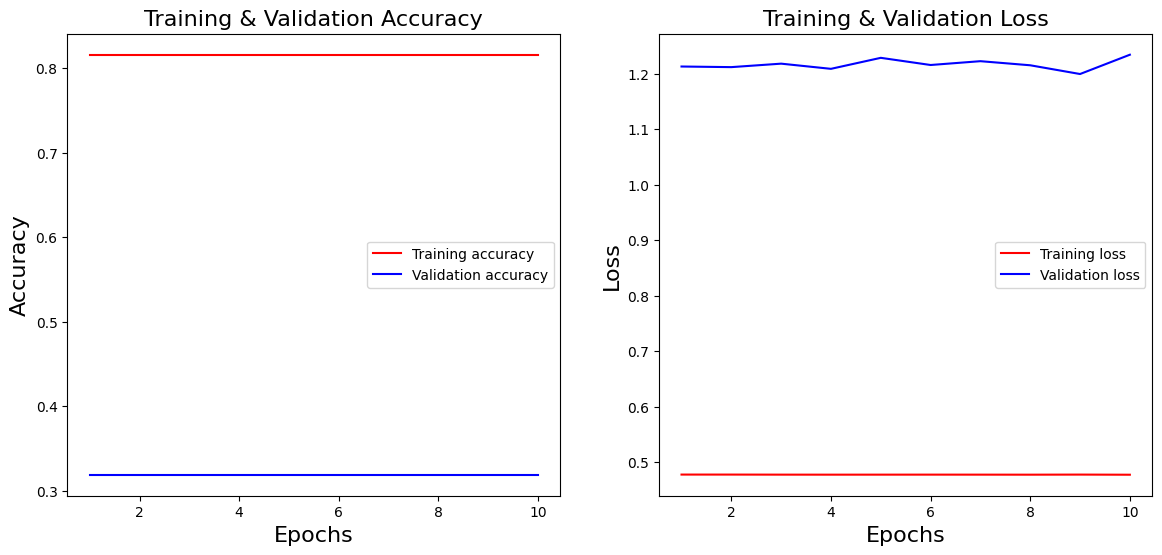

In [ ]:

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()